In [151]:
import torch
import torch.nn as nn
import torchvision

import PIL 
import requests
import zipfile
from pathlib import Path
from typing import Tuple, Dict, List
from timeit import default_timer as timer
import os
from tqdm.auto import tqdm

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
GITHUB_ZIP_LINK = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#IF DIRECTORY EXIST, PASS
if image_path.is_dir():
    print(f"{image_path} directory exists")
#IF DIRECTORY DOES NOT EXIST
else:
    print(f"Didn't find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    #IS ZIP FILE DOWNLOADED?
    if Path(data_path / "pizza_steak_sushi").is_file():
        print(f"pizza_steak_sushi.zip file already exist. Skipping downloading")
    
    #IF NOT, THEN DOWNLOAD
    else:
        print("pizza_steak_sushi.zip file missing. Dowloading...")
        zip_request = requests.get(GITHUB_ZIP_LINK)
        with open(data_path / "pizza_steak_sushi.zip", "wb") as zip_f:
            zip_f.write(zip_request.content)
        print("pizza_steak_sushi.zip downloaded successfully")

    #UNZIP THE ZIP FILE AND CREATE THE DIRECTORY
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as f:
        print("Unzipping pizza, steak, sushi...")
        f.extractall(image_path)       

Didn't find data\pizza_steak_sushi directory, creating one...
pizza_steak_sushi.zip file missing. Dowloading...
pizza_steak_sushi.zip downloaded successfully
Unzipping pizza, steak, sushi...


In [11]:
def walk_through_directory(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [12]:
walk_through_directory(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [13]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [15]:
random.seed(57)

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

Random Image Path: data\pizza_steak_sushi\test\pizza\648055.jpg
Random image Class:  pizza
Image Height : 512
Image Width : 512


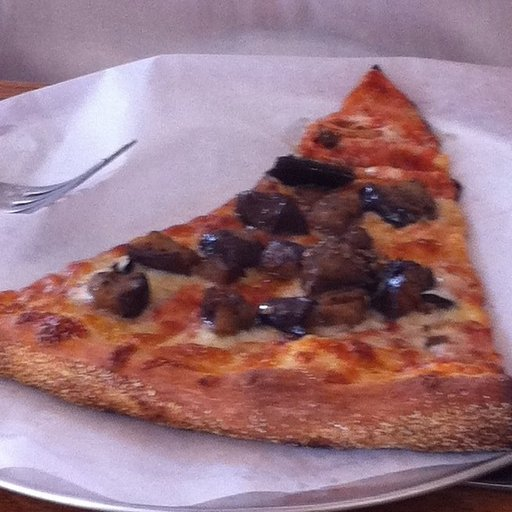

In [56]:
import PIL.Image


random.seed(57)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = PIL.Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Random image Class:  {image_class}")
print(f"Image Height : {img.height}")
print(f"Image Width : {img.width}")
img

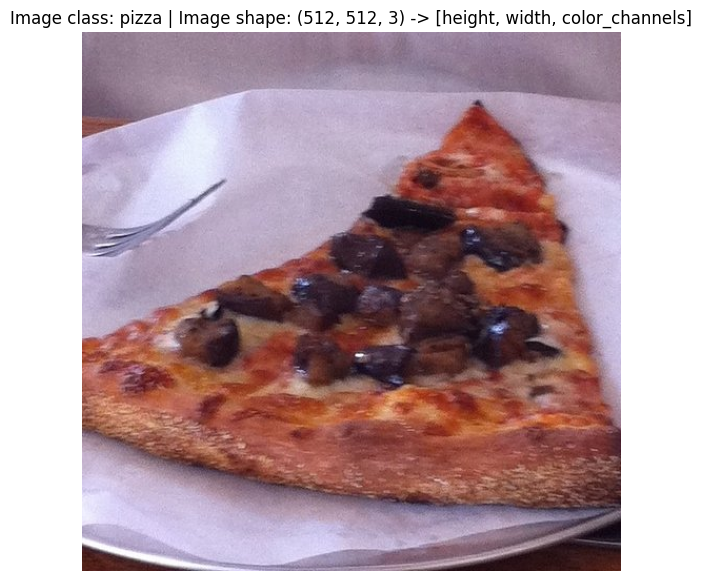

In [24]:
#OR WE CAN USE PLOT.IMSHOW(). BUT FIRST, WE MUST MAKE OUR IMAGE NumPy ARRAY
img_as_array = np.asanyarray(img)
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.imshow(img_as_array)


In [43]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64,64)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5), #PROBABILITY OF FLIP
    torchvision.transforms.ToTensor()
    ])

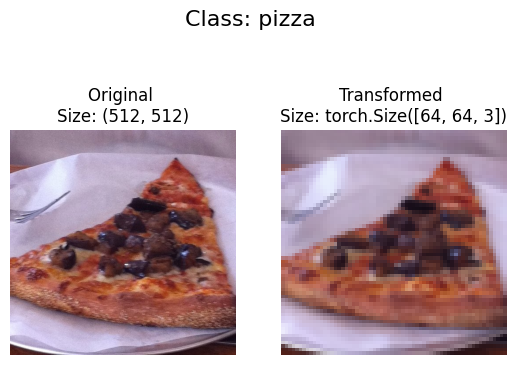

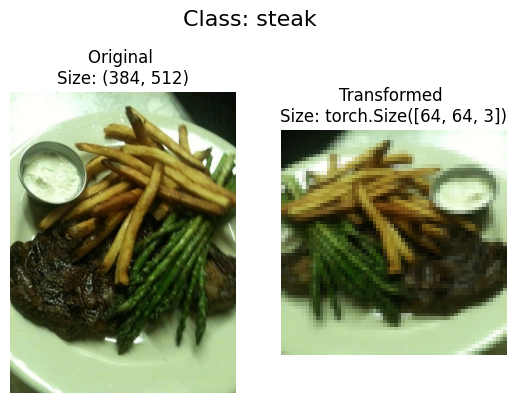

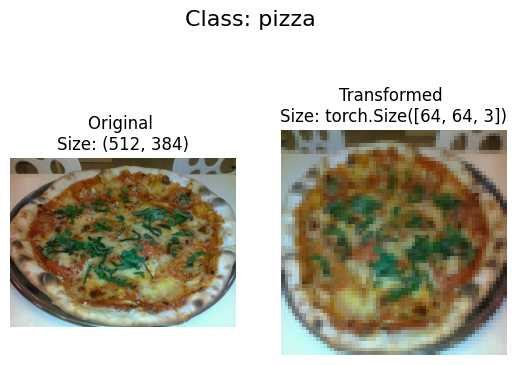

In [44]:
def plot_transformed_images(image_paths, transform, n=3, seed=57):
    random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with PIL.Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            #TRANSFORM AND PLOT THE IMAGE
            #Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_path_list, transform= data_transform)

In [45]:
train_data = torchvision.datasets.ImageFolder(
    root= train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = torchvision.datasets.ImageFolder(
    root= test_dir,
    transform=data_transform
)

print(f"Train Data: {train_data}\nTest Data: {test_data}\n")

Train Data: Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data: Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )



In [46]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [47]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [48]:
len(train_data), len(test_data)

(225, 75)

In [49]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype: {type(label)}")

Image Tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original Shape: torch.Size([3, 64, 64]) --> [color_chanels, height, width]
Image Permute Shape torch.Size([64, 64, 3]) --> [height, width, color_chanels]


Text(0.5, 1.0, 'pizza')

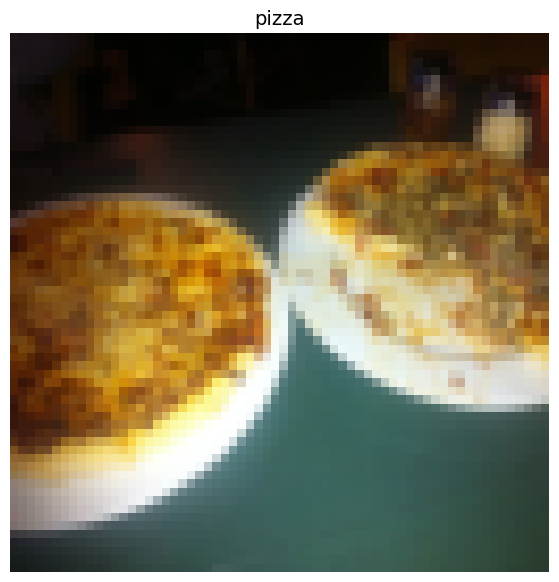

In [50]:
img_permute = img.permute(1,2,0)
print(f"Original Shape: {img.shape} --> [color_chanels, height, width]")
print(f"Image Permute Shape {img_permute.shape} --> [height, width, color_chanels]")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [145]:
#LET'S TURN OUR DATASETS INTO DATALOADERS
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=3,
    shuffle=True,
    num_workers=1
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=3,
    num_workers=1,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1deb1e0d0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1deb4bf6150>)

Image Shape: torch.Size([1, 3, 64, 64])
Label Shape: torch.Size([1])


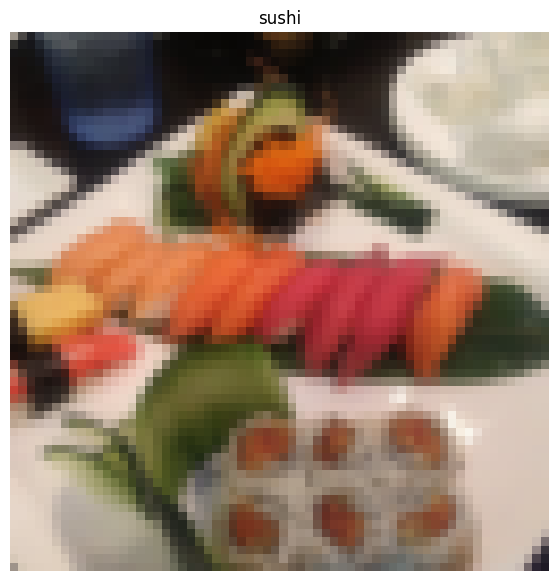

In [55]:
img, label = next(iter(train_dataloader))
img_permute = img.squeeze(dim=0).permute(1,2,0) #[batch_size, color_chanels, height, width] [1, 3, 64, 64]-> 
                                                #use squeeze() and get rid of batch_size [3, 64, 64]
print(f"Image Shape: {img.shape}")
print(f"Label Shape: {label.shape}")
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title(class_names[label])
plt.imshow(img_permute)

In [57]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [58]:
target_directory = train_dir
print(f"Target Directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class Names Found: {class_names_found}")

Target Directory: data\pizza_steak_sushi\train
Class Names Found: ['pizza', 'steak', 'sushi']


In [60]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]: 
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    class_to_idx = {cls_name : i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [61]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [62]:
class ImageFolderCustom(torch.utils.data.Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        #GET ALL IMAGE PATHS
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    
    def load_image(self, index: int) -> PIL.Image.Image:
        image_path = self.paths[index]
        return PIL.Image.open(image_path)
    
    #OVERRIDE __len__ METHOD, OPTIONAL BUT RECOMMENDED FOR SUBCLASSES OF torch.utils.data.Dataset
    def __len__(self) -> int:
        return len(self.paths)
    
    #OVERRIDE THE __getitem__ METHOD, REQUOIRED
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name    
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx    

In [63]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64,64)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64,64)),
    torchvision.transforms.ToTensor()
])


In [64]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1de80eeafd0>,
 <__main__.ImageFolderCustom at 0x1de80ee6590>)

In [65]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [66]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [67]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [68]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [69]:
def display_random_images(
        dataset: torch.utils.data.Dataset,
        classes: List[str] = None,
        n: int = 10,
        display_shape: bool = True,
        seed: int = 57
        ):

    if n > 10:
        n= 10
        display_shape = False
        print(f"For display purposess, n shouldn't be greate than 10. Set to 10")

    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k = n)

    plt.figure(figsize=(16,8))

    # 6. Loop through samples and display random samples 
    for i, random_index in enumerate(random_samples_idx):
        target_image, target_label = dataset[random_index][0], dataset[random_index][1]
        target_image_permute = target_image.permute(1,2,0)

        plt.subplot(1, n, i+1)
        plt.imshow(target_image_permute)
        plt.axis("off")
        if classes:
            title = (f"Class: {classes[target_label]}")
            if display_shape:
                title += f"\nShape: {target_image_permute.shape}"
        plt.title(title)

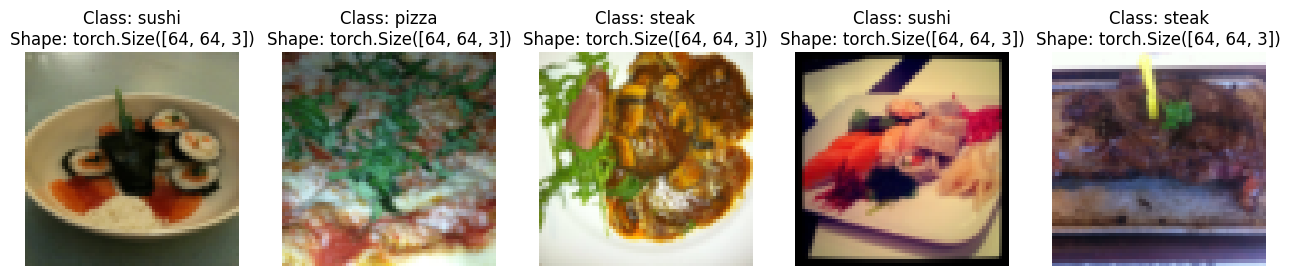

In [73]:
display_random_images(
    dataset=train_data_custom,
    n=5,
    classes=class_names,
    display_shape=True,
    seed=None
)

For display purposess, n shouldn't be greate than 10. Set to 10


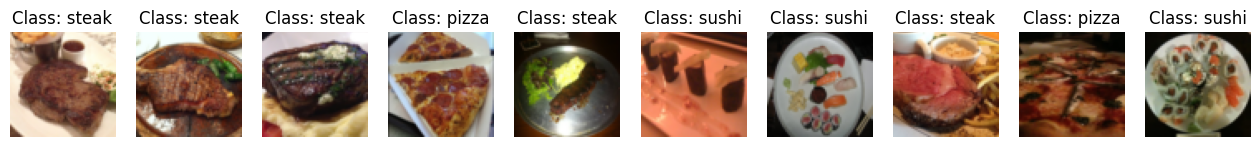

In [71]:
display_random_images(
    dataset=train_data,
    n=15,
    classes=class_names,
    seed=None
)

In [74]:
import torch.utils.data.dataloader


train_dataloader_custom = torch.utils.data.DataLoader(
    dataset=train_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

test_dataloader_custom = torch.utils.data.DataLoader(
    dataset=test_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=False
)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1de8145d0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1de80eea690>)

In [78]:
img_custom, label_custom = next(iter(train_dataloader_custom))
print(f"Image shape: {img_custom.shape} -> [batch_size, color_chanels, heigth, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_chanels, heigth, width]
Label shape: torch.Size([1])


In [79]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

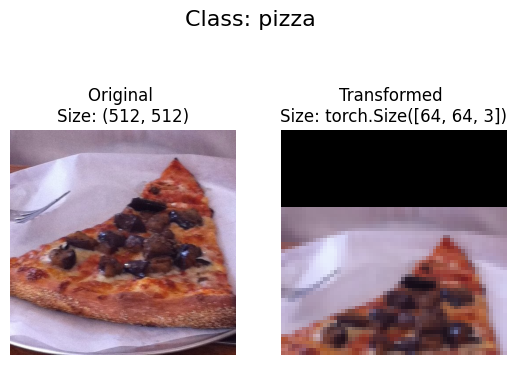

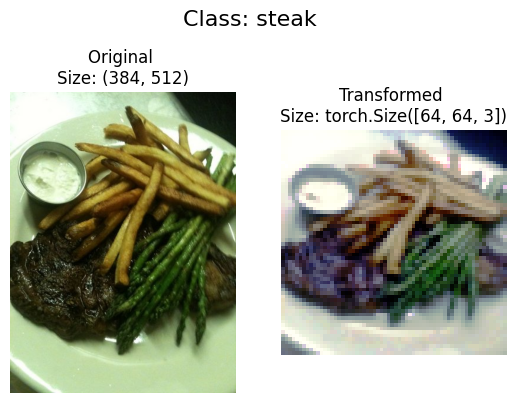

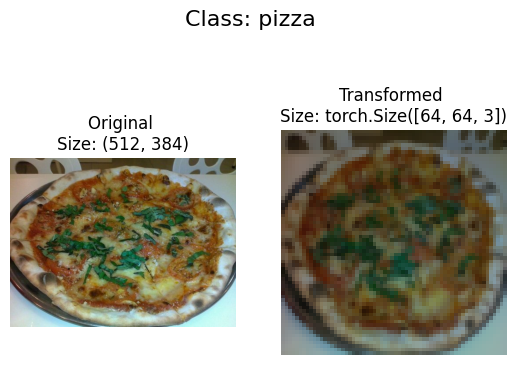

In [80]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=57
)

In [81]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [83]:
torch.manual_seed(57)
model_0 = TinyVGG(
    input_shape=3, #input_shape: number of chanels. that's why we multiply it by [size * (1/2)^(n_max_pool)]^2
    hidden_units=16, 
    output_shape= len(train_data.classes)
    ).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=3, bias=True)
  )
)

In [84]:
image_batch, label_batch = next(iter(train_dataloader))
print(f"Image -in batch- shape: {image_batch.shape}")

Image -in batch- shape: torch.Size([1, 3, 64, 64])


In [87]:
try:
    import torchinfo
    print("Successfully imported torchinfo")
except:
    print("torchinfo library missing. downloading...")
    %pip install torchinfo

from torchinfo import summary
summary(model_0, input_size=[image_batch.shape])

Successfully imported torchinfo


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
│    └─ReLU: 2-2                         [1, 16, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 16, 64, 64]           2,320
│    └─ReLU: 2-4                         [1, 16, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-7                         [1, 16, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-9                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 16, 16, 16]           --
├─Seq

In [102]:
def train_step(
        model: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: nn.CrossEntropyLoss,
        optimizer: torch.optim.Optimizer,
        device: torch.device = device
):
    model.to(device)
    model.train()
    
    train_loss, train_acc = 0, 0
    for batch_index, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [103]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.CrossEntropyLoss,
    device: torch.device = device
):
    model.to(device)

    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch_index, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [104]:

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
    epochs: int = 5,
    devi: torch.device = device):

    results = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer)
        
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    
    return results

In [146]:
torch.manual_seed(57)
torch.cuda.manual_seed(57)

NUM_EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

start_time = timer()
model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:06<00:58,  6.47s/it]

Epoch: 1 | train_loss: 1.1021 | train_acc: 0.3289 | test_loss: 1.1012 | test_acc: 0.3333


 20%|██        | 2/10 [00:12<00:49,  6.23s/it]

Epoch: 2 | train_loss: 1.1011 | train_acc: 0.3067 | test_loss: 1.0989 | test_acc: 0.3333


 30%|███       | 3/10 [00:18<00:42,  6.13s/it]

Epoch: 3 | train_loss: 1.0996 | train_acc: 0.3467 | test_loss: 1.1007 | test_acc: 0.3333


 40%|████      | 4/10 [00:24<00:36,  6.08s/it]

Epoch: 4 | train_loss: 1.0999 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333


 50%|█████     | 5/10 [00:30<00:30,  6.06s/it]

Epoch: 5 | train_loss: 1.1004 | train_acc: 0.3156 | test_loss: 1.1002 | test_acc: 0.3333


 60%|██████    | 6/10 [00:36<00:24,  6.06s/it]

Epoch: 6 | train_loss: 1.1016 | train_acc: 0.2711 | test_loss: 1.0983 | test_acc: 0.3333


 70%|███████   | 7/10 [00:42<00:18,  6.03s/it]

Epoch: 7 | train_loss: 1.1020 | train_acc: 0.2933 | test_loss: 1.1041 | test_acc: 0.3333


 80%|████████  | 8/10 [00:48<00:12,  6.01s/it]

Epoch: 8 | train_loss: 1.1011 | train_acc: 0.3200 | test_loss: 1.1049 | test_acc: 0.3333


 90%|█████████ | 9/10 [00:54<00:06,  6.00s/it]

Epoch: 9 | train_loss: 1.1033 | train_acc: 0.3467 | test_loss: 1.1008 | test_acc: 0.3333


100%|██████████| 10/10 [01:00<00:00,  6.08s/it]

Epoch: 10 | train_loss: 1.1023 | train_acc: 0.3067 | test_loss: 1.1017 | test_acc: 0.3333
Total training time: 60.841 seconds


In [149]:
def plot_loss_curves(results: Dict[str , List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(loss))
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="Train Loss")
    plt.axhline(y=np.array(loss).mean(), linestyle="--", label = "Mean Train Loss", color="blue")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.axhline(y=np.array(test_loss).mean(), linestyle="--", label="Mean Test Loss", color="orange")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="Train Accuracy")
    plt.axhline(y=np.array(accuracy).mean(), linestyle="--", label="Mean Train Accuracy", color="blue")
    plt.plot(epochs, test_accuracy, label="Test Accuracy")
    plt.axhline(y=np.array(test_accuracy).mean(), linestyle="--", label="Mean Test Accuracy", color="orange")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.show()

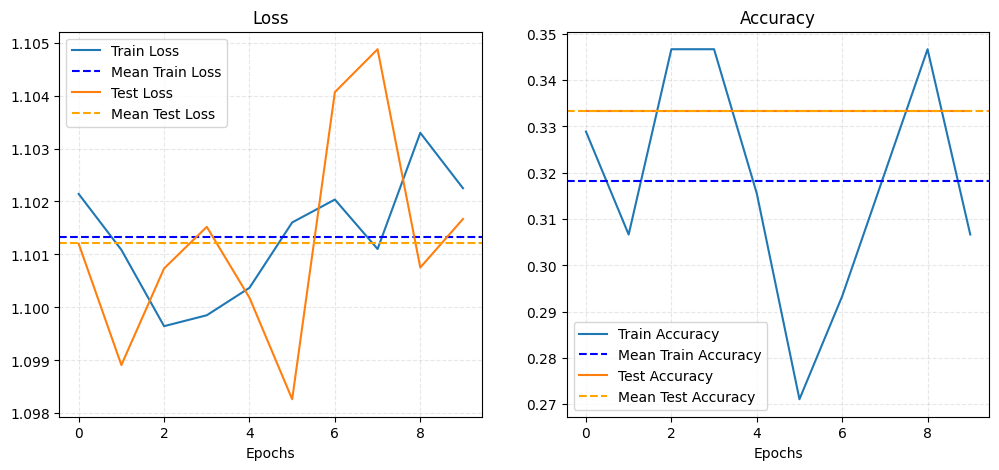

In [150]:
plot_loss_curves(results=model_0_results)

In [154]:
#APPARENTLY OUR MODEL COULDN'T LEARN -- AACCURACY ROUGHLY 0.33, WHICH IS RIDICULOUS :)

GITHUB_DAD_IMG_LINK = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
custom_image_path = data_path / "04-pizza-dad.jpeg"

if not Path(custom_image_path).is_file():
    print(f"pizza-dad file missing. Downloading...")
    request = requests.get(GITHUB_DAD_IMG_LINK)
    with open(custom_image_path, "wb") as f:
        f.write(request.content)
        print("Download successfully completed")

else:
    print(f"{custom_image_path} already exists, skipping download.")

pizza-dad file missing. Downloading...
Download successfully completed


In [155]:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [156]:
model_0.eval()
with torch.inference_mode():
    model_0(custom_image_uint8)

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [157]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

Text(0.5, 1.0, 'Image Shape: torch.Size([3, 4032, 3024])')

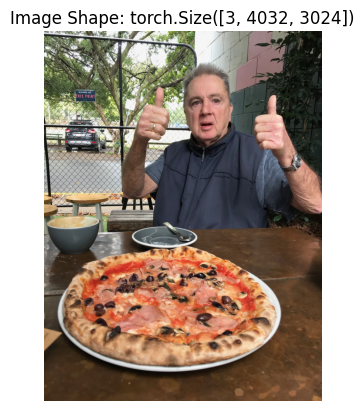

In [158]:
plt.imshow(custom_image.permute(1,2,0))
plt.axis("off")
plt.title(f"Image Shape: {custom_image.shape}")

In [163]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original Shape: {custom_image.shape}")
print(f"New Shape: {custom_image_transformed.shape}")

Original Shape: torch.Size([3, 4032, 3024])
New Shape: torch.Size([3, 64, 64])


In [164]:
model_0.eval()
with torch.inference_mode():
    model_0(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [165]:
model_0.eval()
with torch.inference_mode():
    custom_image_pred = model_0(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x256 and 4096x3)

In [168]:
model_0.eval()
with torch.inference_mode(): #Adds a dimension of size 1 at position dim.
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0).to(device) 

    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [179]:
custom_image_softmax = torch.softmax(custom_image_pred, dim=1)
custom_image_argmax = torch.argmax(custom_image_softmax, dim=1)

list(class_dict.values())[custom_image_argmax.item()]

0

In [ ]:
print(f"Preds: {custom_image_pred}")
custom_image_softmax = torch.softmax(custom_image_pred, dim=1)
custom_image_argmax = torch.argmax(custom_image_softmax, dim=1)
custom_image_class = class_dict

print(f"Probabilities : ")
print(f"Probabilities: {custom_image_softmax}")
print(f"Predicted label: {custom_image_argmax}")


Probabilities : tensor([[0.3489, 0.3305, 0.3206]], device='cuda:0')
Predicted label: tensor([0], device='cuda:0')
